In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import arviz as az
import pymc3 as pm
import theano.tensor as tt
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [9]:
# Read the data
howell1 = pd.read_csv('Data/Howell1.csv',sep=';')

# Normalize the age column
howell1['age'] = StandardScaler().fit_transform(howell1['age'].values.reshape(-1,1))

# Divide dataframe into two equal
d1, d2 = train_test_split(howell1, test_size=0.5, random_state=42)

In [10]:
d1.describe()

,height,weight,age,male
count,272.000000,272.000000,272.000000,272.000000
mean,139.846248,36.518423,-0.007330,0.459559
std,26.206521,14.259042,0.981193,0.499280
min,55.880000,4.847764,-1.415702,0.000000
25%,130.340100,24.408919,-0.788525,0.000000
50%,149.225000,41.276872,-0.161348,0.000000
75%,157.638750,47.520849,0.610562,1.000000
max,172.999400,58.825212,2.829802,1.000000


## Polynomial models

In [11]:
from sklearn.preprocessing import PolynomialFeatures
def plot_polynomial_regressions(d1, xcol, ycol, degree=1, credible_interval=.95, plot_name='hpd', save_plot=True):

    yval = d1[ycol].values
    # Polynomial features
    polynomial_features= PolynomialFeatures(degree=degree, include_bias=False)
    xval = polynomial_features.fit_transform(d1[xcol].values.reshape(-1,1))
    
    with pm.Model() as model_1:
        a = pm.Normal('a', mu=10, sigma=10)
        b = pm.Normal('b', mu=0, sigma=100,shape=(degree))
        sigma = pm.Uniform('sigma', lower=0, upper=10)
        mu = pm.Deterministic('mu', a + tt.dot(xval,b))
        h = pm.Normal('h', mu=mu, sigma=sigma, observed=yval)
#         map_1 = pm.find_MAP()
        trace_1 = pm.sample(cores=2)
    
    if plot_name=='forest':
        az.plot_forest(trace_1, var_names=['a','b','sigma'], figsize=(6,6), credible_interval=credible_interval)
    
    if plot_name=='hpd':
        fig, ax = plt.subplots(figsize=(6,6))
        mu_mean = trace_1['mu']
        ax.scatter(xval[:,0], yval)
        sorted_xval = np.argsort(xval[:,0])
        ax.plot(xval[sorted_xval,0], mu_mean.mean(0)[sorted_xval], 'C1')

        xseq = np.linspace(np.min(xval[:,0]), np.max(xval[:,0]), 50)
        xplot = polynomial_features.fit_transform(xseq.reshape(-1,1)).T
        mu_pred = trace_1['a'].reshape(-1,1) + np.dot(trace_1['b'],xplot)
        ax.plot(xseq, mu_pred.mean(0), 'k.')
        az.plot_hpd(xseq, mu_pred,
                fill_kwargs={'alpha': 0},
                plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'},ax=ax, credible_interval=credible_interval)
        ax.set_xlabel(xcol)
        ax.set_ylabel(ycol)

    if plot_name=='summary':
        print(az.summary(trace_1, ['a','b','sigma'], credible_interval=credible_interval).round(3))
    
    if save_plot:
        filename = 'PolynomialModel_Degree_%d.png' % degree
        plt.savefig(filename)
    model_1.name = 'M%d' % degree
    return model_1,trace_1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 940.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:09<00:00, 200.87draws/s]
The acceptance probability does not match the target. It is 0.8878180625569175, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:13<00:00, 144.49draws/s]
The acceptance probability does not match the target. It is 0.8927018841659955, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assi

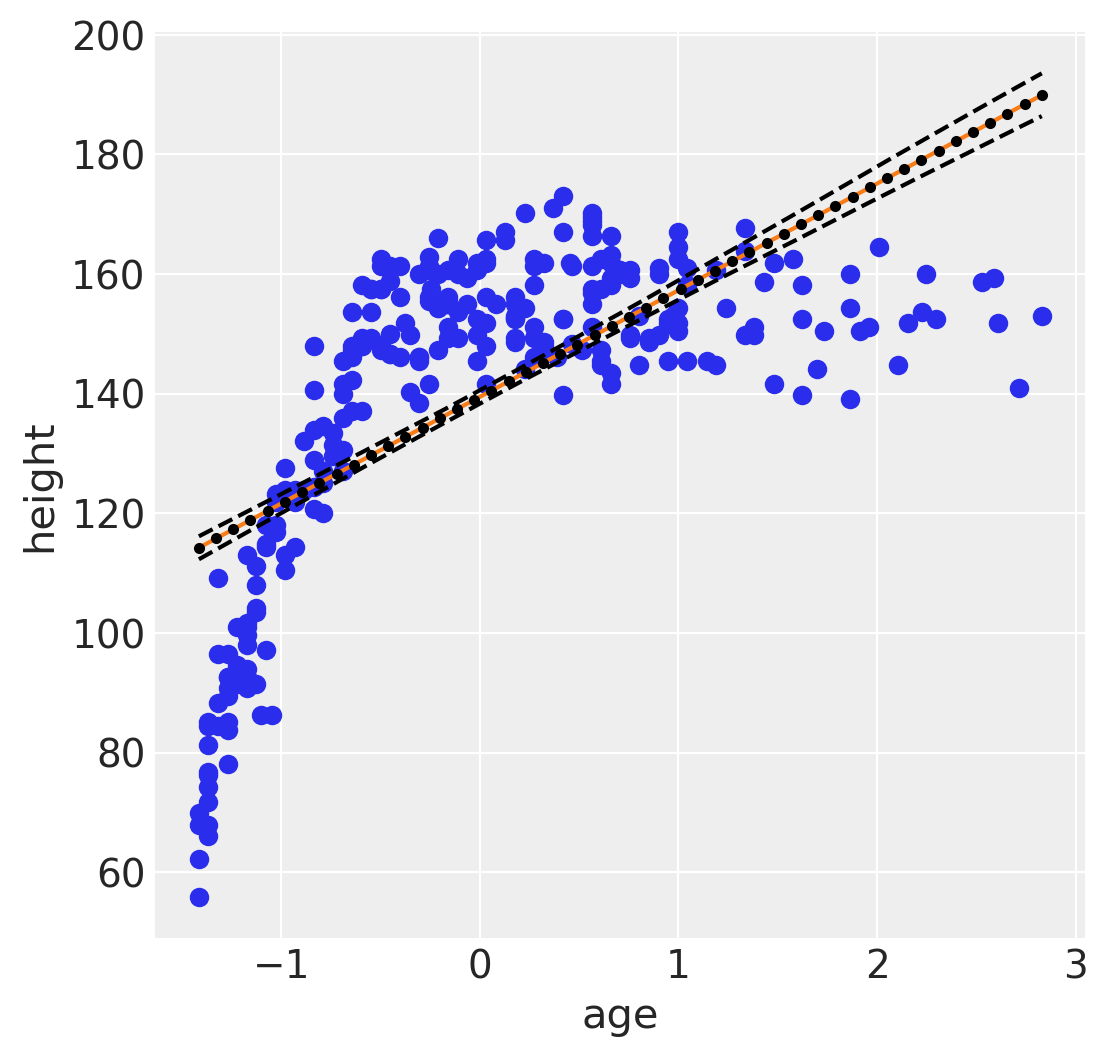

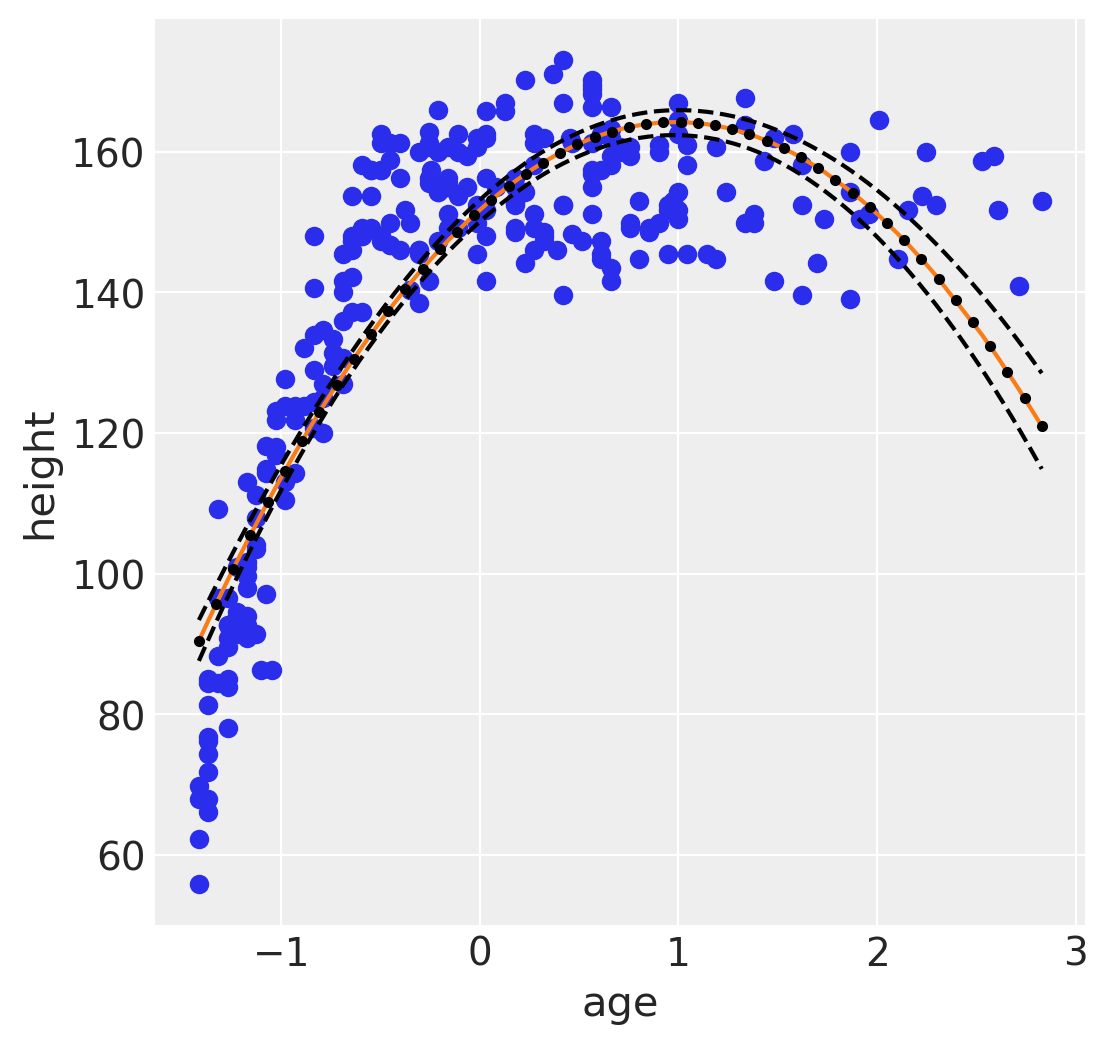

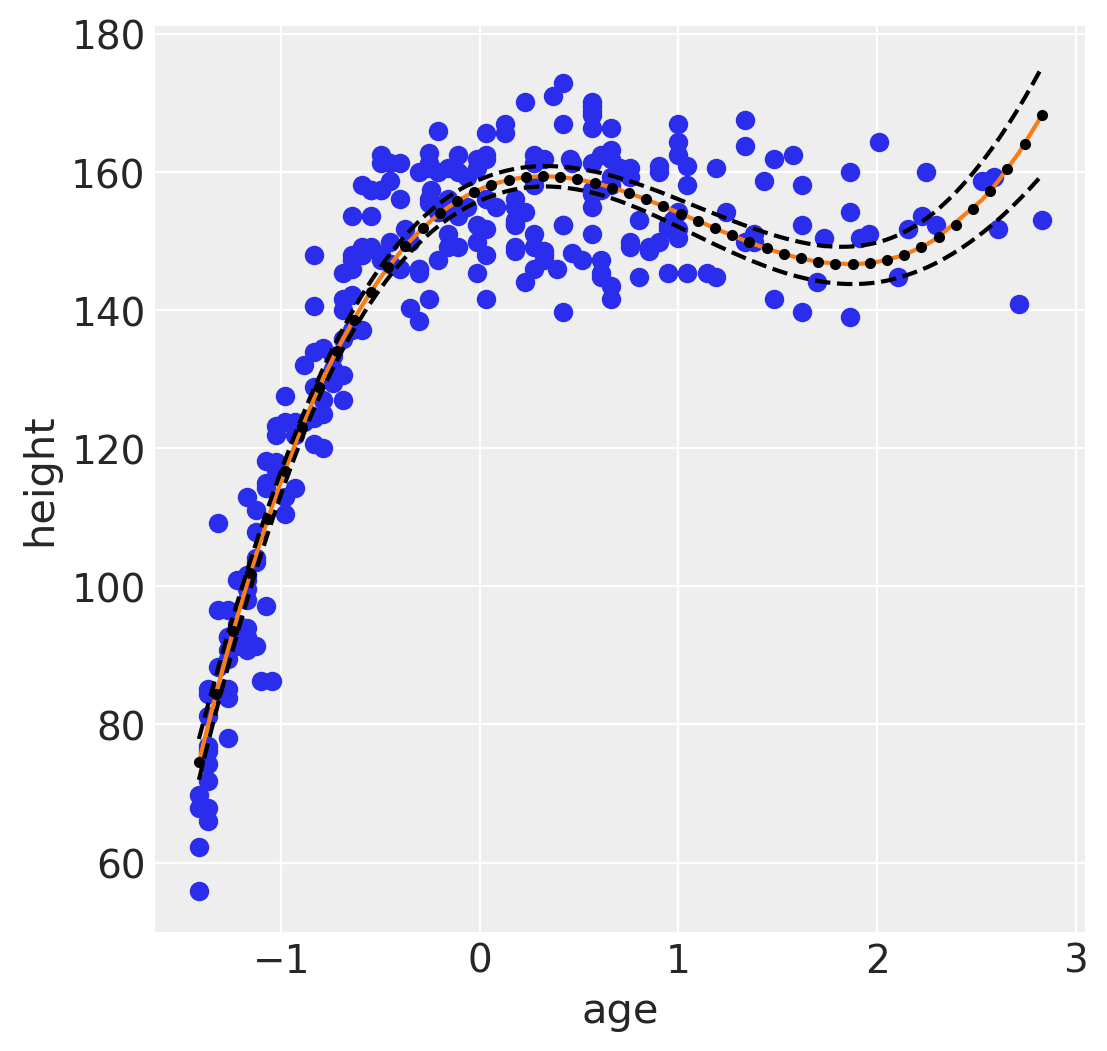

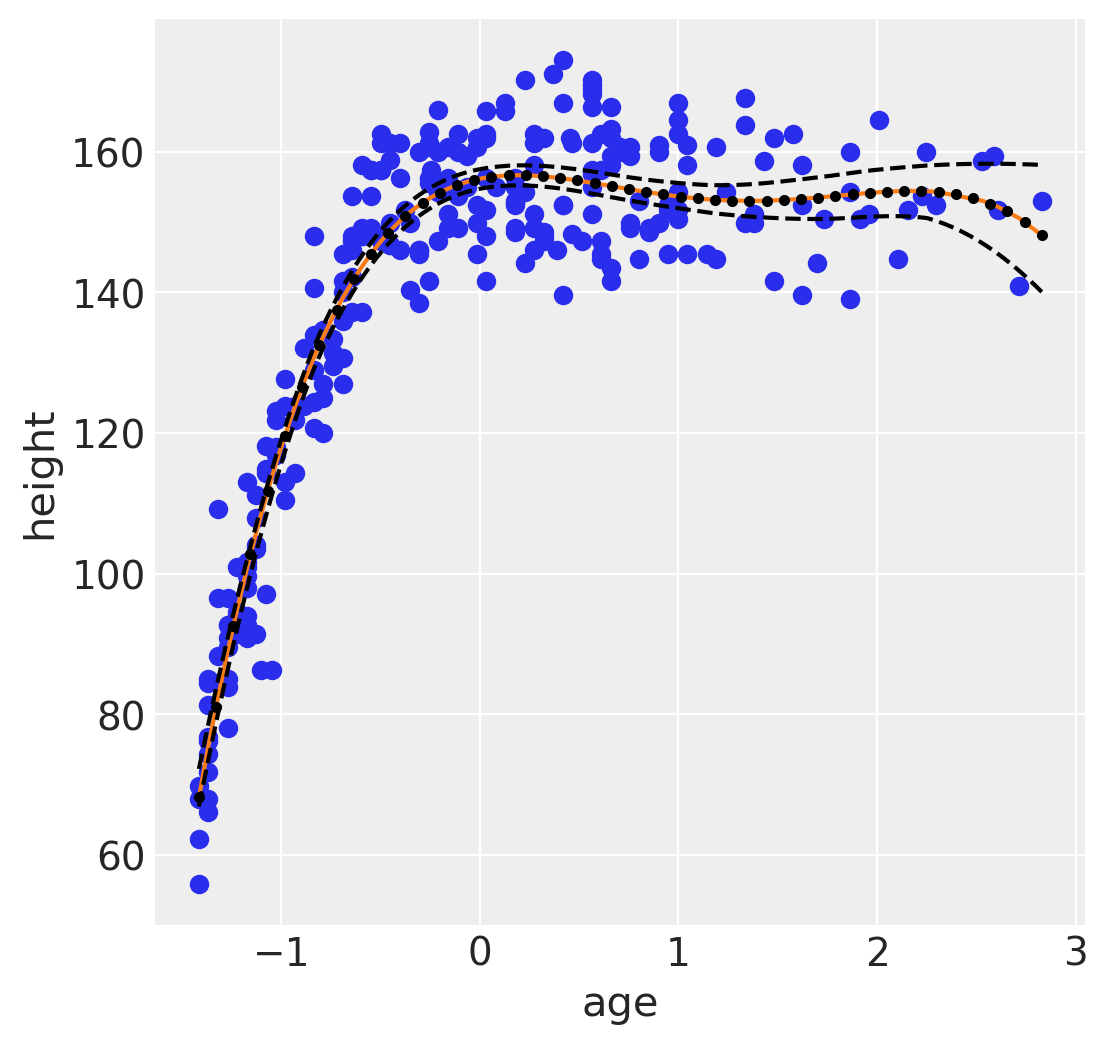

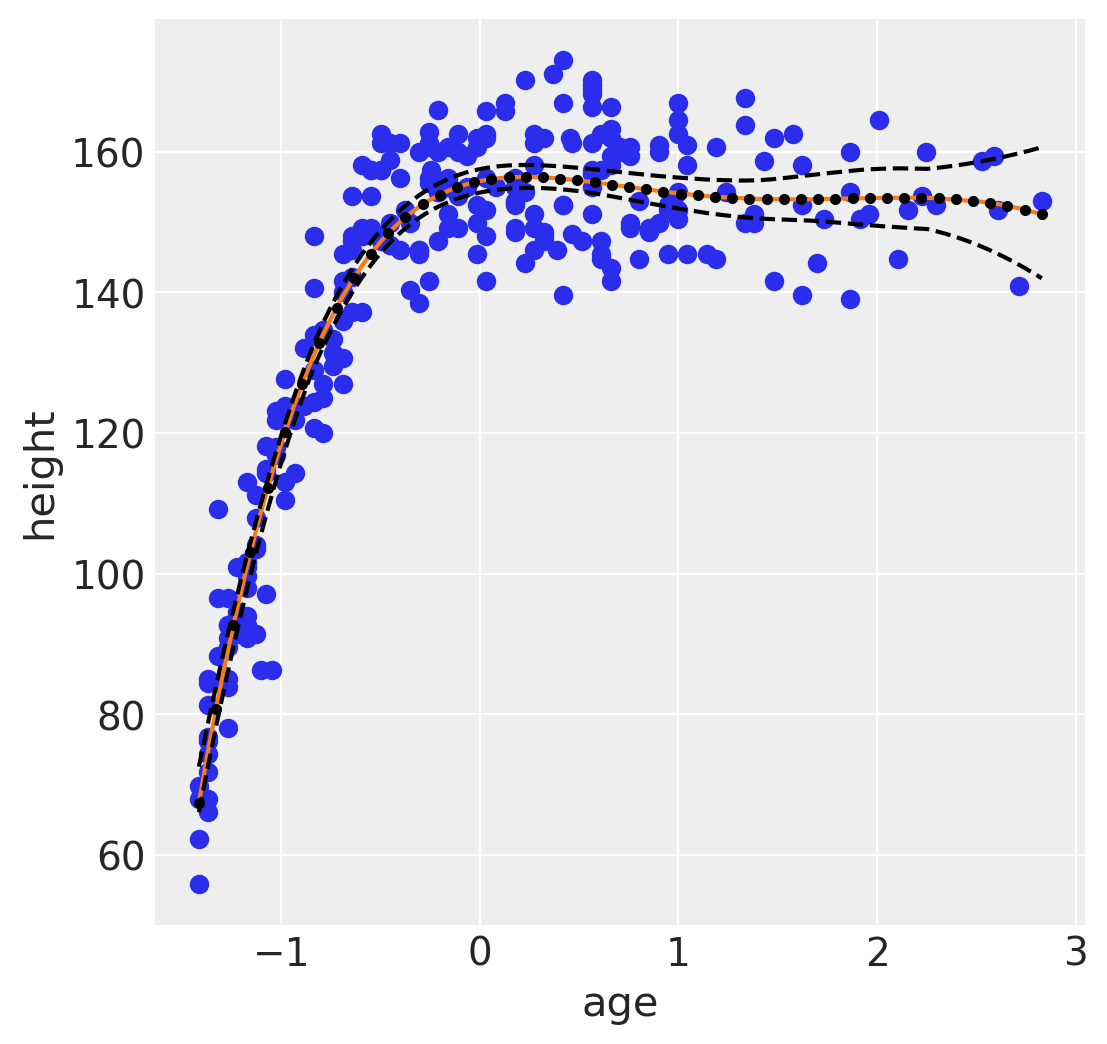

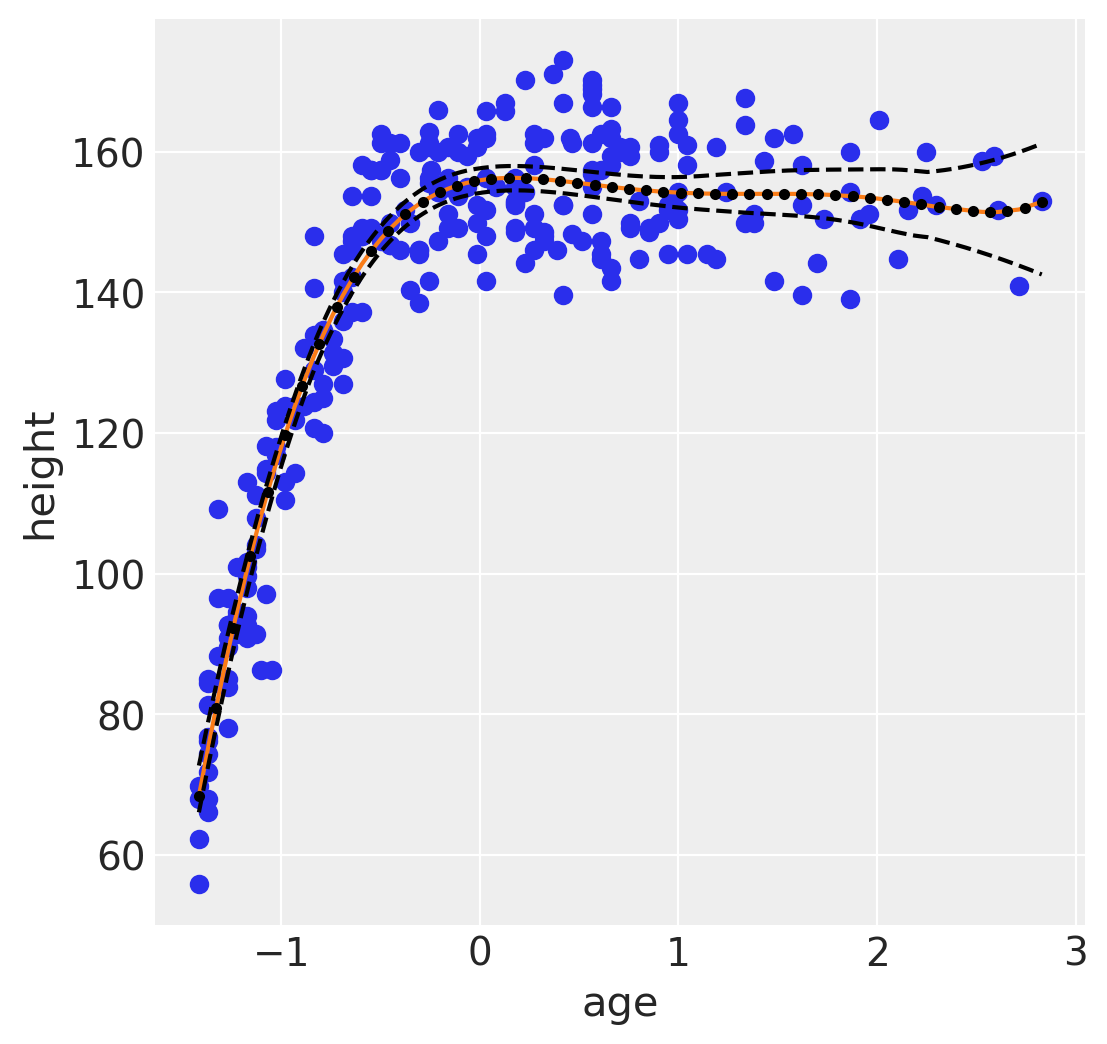

In [12]:
M1,trace1 = plot_polynomial_regressions(d1, xcol='age', ycol='height',degree=1)
M2,trace2 = plot_polynomial_regressions(d1, xcol='age', ycol='height',degree=2)
M3,trace3 = plot_polynomial_regressions(d1, xcol='age', ycol='height',degree=3)
M4,trace4 = plot_polynomial_regressions(d1, xcol='age', ycol='height',degree=4)
M5,trace5 = plot_polynomial_regressions(d1, xcol='age', ycol='height',degree=5)
M6,trace6 = plot_polynomial_regressions(d1, xcol='age', ycol='height',degree=6)

In [13]:
df_comp_WAIC = pm.compare({'M1':trace1, 'M2':trace2, 'M3':trace3, 'M4':trace4, 'M5':trace5, 'M6':trace6})
df_comp_WAIC

/home/amit/anaconda3/envs/streamlit/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
M4,0,1905.89,5.60812,0,0.623829,22.4422,0,True,deviance
M6,1,1908.48,7.19546,2.59179,0.211924,81.0773,1.80804,True,deviance
M5,2,1908.86,6.73244,2.97471,0.163942,32.8663,1.52327,True,deviance
M3,3,1946.43,6.18354,40.5411,0.000304816,23.9653,13.8289,True,deviance
M2,4,2178.95,7.20268,273.06,8.55626e-41,23.6657,33.4979,True,deviance
M1,5,2800.65,9.55683,894.765,8.4857e-152,23.377,81.5271,True,deviance


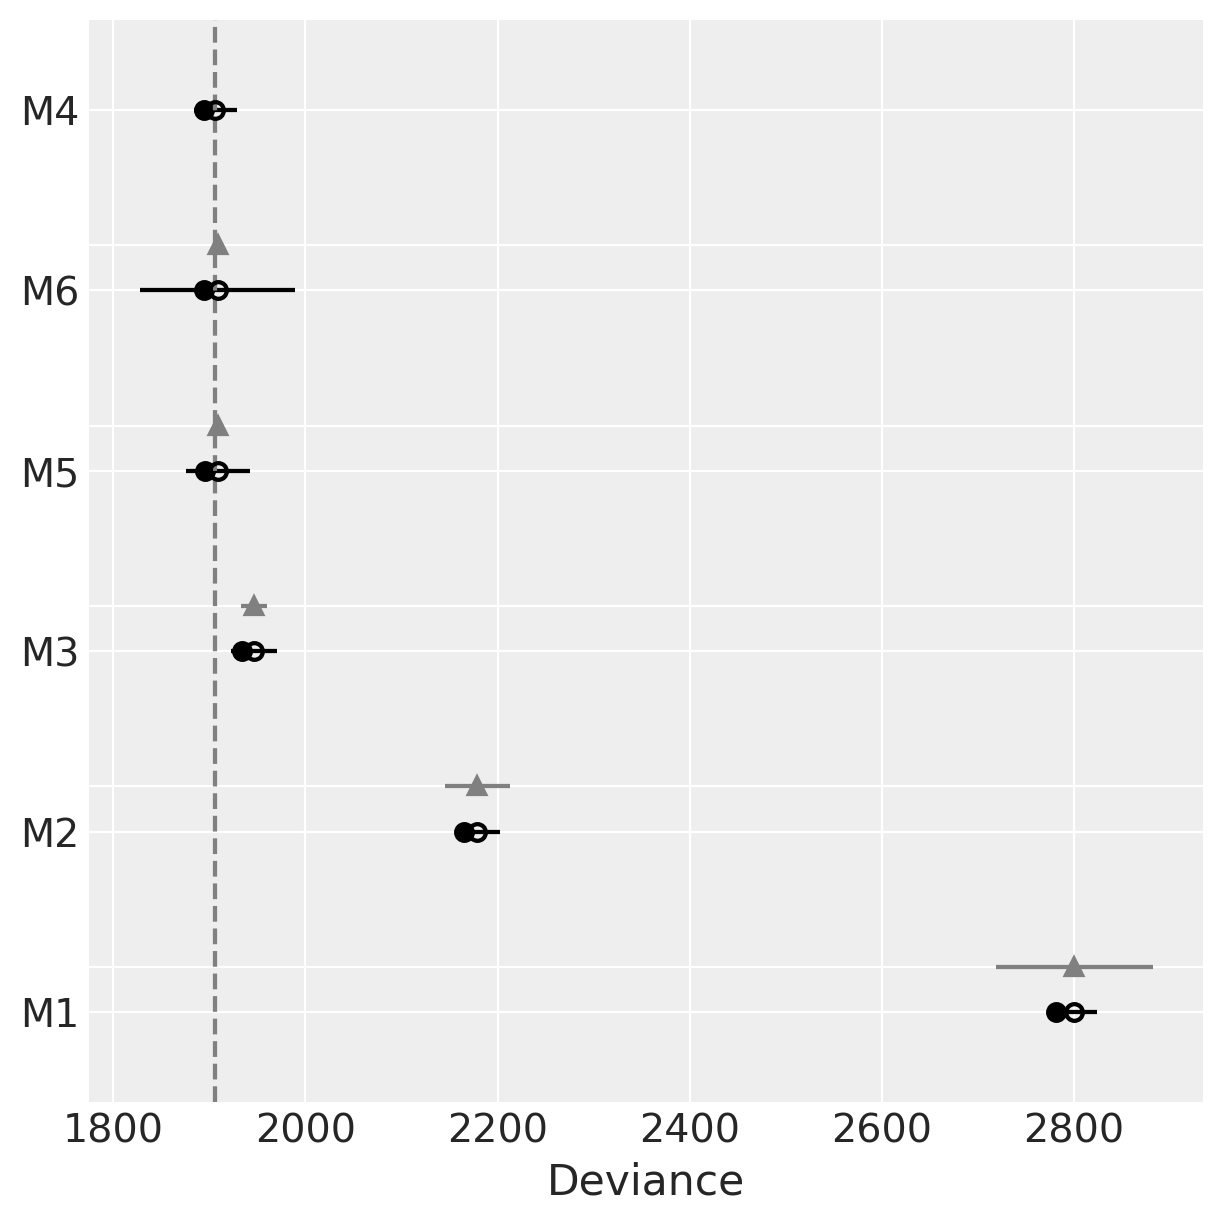

In [14]:
pm.compareplot(df_comp_WAIC)